# 常数和特殊函数

## 物理常量 

In [2]:
from scipy import constants as C
print("光速：",C.c)
print('普朗克常数：',C.h)

光速： 299792458.0
普朗克常数： 6.62607004e-34


## 常用单位

In [6]:
print('一英里：',C.mile)
print('一英寸',C.inch)

一英里： 1609.3439999999998
一英寸 0.0254


## special函数库
Scipy中的special模块是一个非常完整的函数库，其中包含了基本数学函数，特殊数学函数以及numpy中所出现的所有函数。
伽马函数是概率统计学中经常出现的一个特殊函数，它的计算公司如下：
$\Gamma(z)=\int_{0}^{\infty}{t^{z-1}e^{-t}dt}$

In [8]:
from scipy import special as S
print(S.gamma(4))

6.0


# 拟合与优化-optimize
optimize模块提供了许多数值优化算法，这里主要对其中的非线性方程组求解、数值拟合和函数最小值进行介绍

## 非线性方程组求解
fsolve()可以对非线性方程组进行求解，它的基本调用形式为fsolve(func,x0),其中func是计算方程组误差的函数，它的参数x是一个数组，其值为方程组的一组可能的解。func返回将x代入方程组之后得到的每个方程的误差，x0为未知数的一组初始解

In [17]:
from math import sin,cos
from scipy import optimize
def f(x):
    x0,x1,x2=x.tolist()
    return [
        5*x1+3,
        4*x0*x0-2*sin(x1*x2),
        x1*x2-1.5
    ]
result=optimize.fsolve(f,[1,-1,1])
print(result)
print(f(result))

[ 0.70622057 -0.6        -2.5       ]
[0.0, -8.881784197001252e-16, 0.0]


在对方程组进行求解时，fsolve()会自动计算方程组在某点对各个未知变量的偏导数，这些偏导数组成一个二维数组，数学上称之为雅阁比矩阵。如果方程组中的未知数很多，而与每个方程有关联的未知数较少，即雅各比矩阵比较稀疏的时候，将计算雅各比矩阵的函数最为参数传递给fsolve（），这能大幅度提高运算速度

In [20]:
def j(x):
    x0,x1,x2=x.tolist()
    return [
        [0,5,0],
        [8*x0,-2*x2*cos(x1*x2),-2*x1*cos(x1*x2)],
        [0,x2,x1]
    ]
result=optimize.fsolve(f,[1,-1,1],fprime=j)
print(result)
print(f(result))

[ 0.70622057 -0.6        -2.5       ]
[0.0, -8.881784197001252e-16, 0.0]


## 最小二乘拟合
在optimize模块中，可以使用leastsq()对数据进行最小二乘拟合。只需要将计算误差的函数和待确定参数的初始值传递给它即可。

In [22]:
import numpy as np
from scipy import optimize
x= np.array([8.19,2.72,6.39,8.71,4.7,2.66,3.78])
y=np.array([7.01,2.78,6.47,6.71,4.1,4.23,4.05])

def residuals(p):
    k,b=p
    return y-(k*x+b)
r=optimize.leastsq(residuals,[1,1])
print(r)
    

(array([0.61349535, 1.79409255]), 3)


接下来是一个拟合正弦波函数的例子

真实参数： 10 0.34 0.5235987755982988
拟合参数： [9.81307133 0.34167968 0.4651311 ]


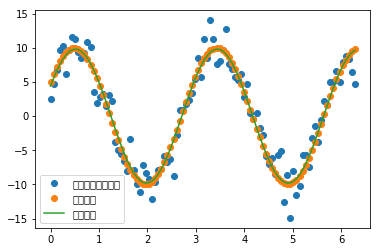

In [36]:
import matplotlib.pyplot as pl 
def func(x,p):
    a,k,theta=p
    return a*np.sin(2*np.pi*k*x+theta)
def residuals(p,y,x):
    return y-func(x,p)
x=np.linspace(0,2*np.pi,100)
a,k,theta=10,0.34,np.pi/6 #真实参数
y0=func(x,[a,k,theta])
y1=y0+2*np.random.randn(len(x))#随机噪声
p0=[7,0.4,0]#第一次试错参数
plsq=optimize.leastsq(residuals,p0,args=(y1,x))
print('真实参数：',a,k,theta)
print('拟合参数：',plsq[0])
pl.plot(x,y1,'o',label=u'带噪声的实验数据')
pl.plot(x,y0,'o',label=u'真实数据')
pl.plot(x,func(x,plsq[0]),label=u'拟合数据')
pl.legend(loc='best')
pl.show()

 对于这种一维曲线拟合，optimize库还提供了一个curve_fit()函数，她的目标函数与leastsq稍有不同，各个待优化参数直接作为函数的参数传入

In [37]:
def func2(x,A,k,theta):
    return A*np.sin(2*np.pi*k*x+theta)
popt,_=optimize.curve_fit(func2,x,y1,p0=p0)
print(popt)

[9.81307133 0.34167968 0.46513111]


## 计算函数局域最小值
optimize库还提供了许多求函数最小值的算法：Nelder-Mead,Powell,CG,BFGS,Newton-CG,L-BFGS-B等。下面将使用$f(x,y)={(1-x)}^2+100{(y-x^2)}^2$来实现各个算法


In [11]:
import numpy as np
from scipy import optimize
def target_func(x,y):
    return (1-x)**2+(y-x**2)**2
class Target_function(object):
    def __init__(self):
        self.f_points=[]
        self.fprime_points=[]
        self.fhess_points=[]
        
    def f(self,p):
        x,y=p.tolist()
        z=target_func(x,y)
        self.f_points.append((x,y))
        return z
    def fprime(self,p):
        x,y=p.tolist()
        self.fprime_points.append((x,y))
        dx=-2+2*x-100*x*(y-x**2)
        dy=200*y-200*x**2
        return np.array([dx,dy])
    def fhess(self,p):
        x,y=p.tolist()
        self.fhess_points.append((x,y))
        return np.array([[2*(600*x**2-200*y+1),-400*x],[-400*x,200]])
def fmin_demo(meathod):
    target=Target_function()
    init_point=(1,-1)
    res=optimize.minimize(target.f,init_point,method=meathod,jac=target.fprime,hess=target.fhess)
    return res,[np.array(points) for points in (target.f_points,target.fprime_points,target.fhess_points)]
meathods=('Nelder-Mead',"Powell","CG","BFGS","Newton-CG","L-BFGS-B")
for meathod in meathods:
    res,(f_points,fprime_points,fhess_points)=fmin_demo(meathod)
    print(meathod,float(res['fun']),len(f_points),len(fprime_points),len(fhess_points))

Nelder-Mead 3.9257142525324585e-10 88 0 0
Powell 1.3065508742723008e-29 178 0 0
CG 0.34126318409689027 16 4 0
BFGS 0.3618490736691562 59 48 0
Newton-CG 0.8729598762728193 25 14 2
L-BFGS-B 0.007274931919728303 108 108 0


C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:381: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method CG does not use Hessian information (hess).
  RuntimeWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method BFGS does not use Hess

## 计算全域最小值
前面的几种算法，只能计算局域的最小值，optimize还提供了几种能进行全局优化的算法，

In [15]:
import matplotlib.pyplot as pl 
def func(x,p):
    a,k,theta=p
    return a*np.sin(2*np.pi*k*x+theta)
def sum_erro(p,y,x):
    return np.sum((y-func(x,p))**2)
x=np.linspace(0,2*np.pi,100)
a,k,theta=10,0.34,np.pi/6 #真实参数
y0=func(x,[a,k,theta])
y1=y0+2*np.random.randn(len(x))#随机噪声
result=optimize.basinhopping(sum_erro,(1,1,2),niter=30,minimizer_kwargs={'method':'L-BFGS-B',
                                                                         'args':(y1,x)})
print(result)

                        fun: 349.13579066361183
 lowest_optimization_result:       fun: 349.13579066361183
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373675e-05,  6.53699317e-03,  2.16004992e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 212
      nit: 31
   status: 0
  success: True
        x: array([ 9.70865421, -0.34042705,  2.60072193])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 4876
                        nit: 30
                          x: array([ 9.70865421, -0.34042705,  2.60072193])


C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\optimize\_basinhopping.py:299: RuntimeWarning: overflow encountered in exp
  w = min(1.0, np.exp(-(energy_new - energy_old) * self.beta))


# 线性代数 
numpy和scipy都提供了线性代数函数库linalg，但是SciPy的线性代数库比numpy更全面
## 解线性方程组
numpy.linalg.solve(A,b)和scipy.linalg(A,b)都可以用来解线性方程组Ax=b

In [22]:
from scipy import linalg
m,n=500,50
A=np.random.rand(m,m)
B=np.random.rand(m,n)
X1=np.dot(linalg.inv(A),B)
X2=linalg.solve(A,B)
print(X2)
print(np.allclose(X1,X2))
%timeit np.dot(linalg.inv(A),B)
%timeit linalg.solve(A,B)

[[-2.45127873 -0.13882212  1.26994732 ... -0.07598084  0.5579381
   0.11674061]
 [-0.48192061 -0.50430038  0.44186608 ... -0.03831083  0.32654131
  -0.39466819]
 [ 2.75605805 -0.18499216 -2.68391499 ... -0.04944263 -1.2672175
   1.49844271]
 ...
 [-1.18737097 -0.11455363  1.63027891 ... -0.10635036  1.05193909
  -1.18149741]
 [-0.57979299 -0.71344473 -0.21270016 ... -0.12685799 -0.16155777
  -0.26904821]
 [ 3.87852776  0.89917524 -2.85888188 ...  0.49715813 -0.84375228
   0.59423434]]
True
16 ms ± 630 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
125 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 最小二乘解
lstsq()比solve()更一般化，他不要求矩阵A是正方形，也就是说方程的个数可以少于未知数的个数。它找到一组解使得||b-Ax||最小。我们称得到的结果为最小二乘解，即它使得所有的等式的误差的平方和最小。

In [26]:
from numpy.lib.stride_tricks import as_strided
def make_data(m,n,noise_scale):
    np.random.seed(42)
    x=np.random.standard_normal(m)
    h=np.random.standard_normal(n)
    y=np.convolve(x,h)
    yn=y+np.random.standard_normal(len(y))*noise_scale*np.max(y)
    return x,yn,h
def solve_h(x,y,n):
    X=as_strided(x,shape=(len(x)-n+1,n),strides=(x.itemsize,x.itemsize))
    Y=y[n-1:len(x)]
    h=linalg.lstsq(X,Y)
    return print(h[0][::-1])
x,yn,h=make_data(1000,100,0.4)
H1=solve_h(x,yn,120)
print('\n')
H1=solve_h(x,yn,80)

[ 1.02122711  1.12065143 -0.22757846 -1.01482501  1.31553835  0.53934731
  1.31544876  0.93354187  1.27032238 -1.04168272  1.39750754  0.22519527
  1.65410631 -0.96828011  1.79938629  0.11834929 -1.04443277 -0.68345965
  0.04055329  0.7373408   0.26798303 -0.35391692  0.43032291  2.54117049
  1.5931832  -0.47924337 -0.09995263 -0.34079478  0.42672859 -0.57032596
 -0.5692853  -1.33584647  0.67352005  1.15372941 -0.29870762  1.27445328
 -1.31249404 -0.82773274  0.18633994  1.28741445  1.38310911 -0.72534511
  1.63964897  0.20082523 -0.47593153  0.58676419  0.85587444 -1.18609796
  1.33102096  1.4884538  -0.72843958  0.41312483  0.39393151 -0.30053536
 -1.30768415  0.21844389  0.00721972  1.58552414  0.48198959 -1.35023746
  0.95909454 -3.71653816  1.37521461 -2.30624762 -0.34215011 -0.66428877
 -1.79324755  1.43632782  0.39008346  0.4303981  -0.16790823  0.24939367
  0.03675145 -0.94940883  0.67301812 -0.4547047  -1.39794423 -0.81050119
  1.4524133   1.04121964 -0.75267186 -0.63258586 -0

## 特征值和特征向量 

In [27]:
a=np.array([[1,0.3],[0.1,0.9]])
linalg.eig(a)#第一个元组是特征值，第二个是特征向量

(array([1.13027756+0.j, 0.76972244+0.j]), array([[ 0.91724574, -0.79325185],
        [ 0.3983218 ,  0.60889368]]))

# 统计—stats
## 连续概率分布
连续随机变量对象都有如下方法：
- rvs: 对随机变量进行随机取值，可以通过size参数指定输出的数组大小
- pdf: 随机变量的概率密度函数
- cdf: 随机变量的累积分布函数，她是概率密度函数的积分
- sf: 随机变量的生存函数，它的值是1-cdf(t)
- ppf: 累积分布函数的反函数
- stat: 计算随机变量的期望值和方差
- fit: 对一组随机取样进行拟合，找出最适合取样数据的概率密度函数的系数

以下是随机概率分布的所有方法：

In [44]:
from scipy import stats
[k for k,v in stats.__dict__.items() if isinstance(v,stats.rv_continuous)]

['ksone',
 'kstwobign',
 'norm',
 'alpha',
 'anglit',
 'arcsine',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'fisk',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'dgamma',
 'dweibull',
 'expon',
 'exponnorm',
 'exponweib',
 'exponpow',
 'fatiguelife',
 'foldcauchy',
 'f',
 'foldnorm',
 'frechet_r',
 'weibull_min',
 'frechet_l',
 'weibull_max',
 'genlogistic',
 'genpareto',
 'genexpon',
 'genextreme',
 'gamma',
 'erlang',
 'gengamma',
 'genhalflogistic',
 'gompertz',
 'gumbel_r',
 'gumbel_l',
 'halfcauchy',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'gausshyper',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'laplace',
 'levy',
 'levy_l',
 'levy_stable',
 'logistic',
 'loggamma',
 'loglaplace',
 'lognorm',
 'gilbrat',
 'maxwell',
 'mielke',
 'kappa4',
 'kappa3',
 'nakagami',
 'ncx2',
 'ncf',
 't',
 'nct',
 'pareto',
 'lomax',
 'pearson3',
 'powerlaw',
 'powerlognorm',
 'powernorm',
 'rdist',
 'rayleigh',
 'reciprocal',
 'rice',
 'recipinvgauss',
 'semi

以下以正态分布为例，展示相关函数

In [30]:
from scipy import stats
x=stats.norm(loc=1,scale=2)#loc参数指定期望，scale指定标准差
x.stats()

(array(1.), array(4.))

In [32]:
y=x.rvs(size=10000)#对随机变量取10000个值
np.mean(y),np.var(y)

(1.0312783366175413, 4.022155545295567)

有些随机分布除了loc和scale参数之外，还需要额外的形状参数。例如伽马分布可用于描述等待K个独立随机事件发生所需要的时间，k就是伽马分布的形状参数

In [37]:
print(stats.gamma.stats(1))
print(stats.gamma.stats(2.0))

(array(1.), array(1.))
(array(2.), array(2.))


伽马分布的尺度参数$\theta$和随机事件发生的频率有关，由scale参数指定：

In [39]:
stats.gamma.stats(2.0,scale=2.0)

(array(4.), array(8.))

当随机分布有额外的形状参数时，它所对应的rvs()和pdf()等方法都会增加额外的参数来接收形状参数。

In [42]:
x=stats.gamma.rvs(2,scale=2,size=4)
stats.gamma.pdf(x,2,scale=2)

array([0.16915721, 0.17582402, 0.17898158, 0.12960963])

In [43]:
X=stats.gamma(2,scale=2)
X.pdf(x)

array([0.16915721, 0.17582402, 0.17898158, 0.12960963])

## 离散概率分布
以下是离散概率分布的所有方法

In [45]:
[k for k,v in stats.__dict__.items() if isinstance(v,stats.rv_discrete)]

['binom',
 'bernoulli',
 'nbinom',
 'geom',
 'hypergeom',
 'logser',
 'poisson',
 'planck',
 'boltzmann',
 'randint',
 'zipf',
 'dlaplace',
 'skellam']

In [46]:
x=range(1,7)
p=[0.4,0.2,0.1,0.1,0.1,0.1]
dice=stats.rv_discrete(values=(x,p))
dice.rvs(size=20)

array([1, 2, 6, 1, 2, 1, 2, 2, 2, 5, 1, 2, 1, 4, 1, 5, 1, 1, 1, 6])

In [58]:
sample=dice.rvs(size=(20000,50))
sample_mean=np.mean(sample,axis=1)

## 核密度函数 

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


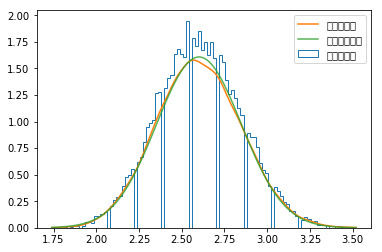

In [61]:
_,bins,step=pl.hist(sample_mean,bins=100,normed=True,histtype='step',label=u'直方统计图')
kde=stats.kde.gaussian_kde(sample_mean)
x=np.linspace(bins[0],bins[-1],100)
pl.plot(x,kde(x),label=u'核密度估计')
mean,std=stats.norm.fit(sample_mean)
pl.plot(x,stats.norm(mean,std).pdf(x),alpha=0.8,label=u'正态分布拟合')
pl.legend()

核密度估计算法是每个数据点放置一条核函数曲线，最终的核密度估计就是所有这些核函数曲线的叠加，gaussian_kde()的核函数为高斯曲线，其中bw_method参数决定了核函数的宽度，即高斯曲线的方差。bw_method参数可以是以下几种情形：
- 当为'scott','silverman'时将采用相应的公式根据数据个数和维数决定核函数的宽度系数
- 当为函数时，将调用此函数计算曲线宽度系数，函数的参数为gaussian_kde对象
- 当为数值时，将直接使用该数值作为宽度系数

核函数的方差由数据的方差和宽度系数决定

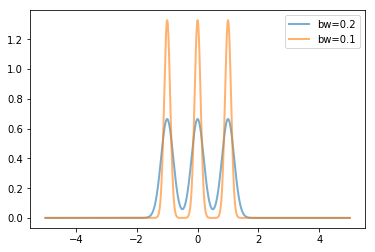

In [72]:
for bw in [0.2,0.1]:
    kde=stats.gaussian_kde([-1,0,1],bw_method=bw)
    x=np.linspace(-5,5,1000)
    y=kde(x)
    pl.plot(x,y,lw=2,label='bw={}'.format(bw),alpha=0.6)
pl.legend(loc='best')

## 二项分布，泊松分布，伽马分布
### 二项分布

In [1]:
from scipy import stats
stats.binom.pmf(range(6),5,1/6.0)

array([4.01877572e-01, 4.01877572e-01, 1.60751029e-01, 3.21502058e-02,
       3.21502058e-03, 1.28600823e-04])

该结果分别表示出现每个数1-5次的概率

### 泊松分布

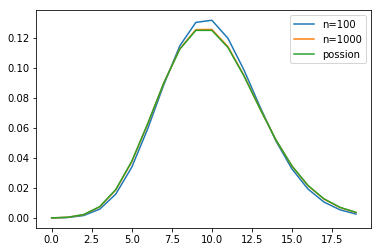

In [7]:
import numpy as np
import matplotlib.pyplot as pl
lambda_=10.0
x=np.arange(20)
n1,n2=100,1000
y_binom_n1=stats.binom.pmf(x,n1,lambda_/n1)
y_binom_n2=stats.binom.pmf(x,n2,lambda_/n2)
y_possion=stats.poisson.pmf(x,lambda_)
pl.plot(x,y_binom_n1,label='n=100')
pl.plot(x,y_binom_n2,label='n=1000')
pl.plot(x,y_possion,label='possion')
pl.legend(loc="best")

二项分布足够大时，将会无限接近泊松分布

### 伽马分布
观察相邻两个事件之间的时间间隔的分布情况，或者隔k个时间的时间间隔的分布情况，根据概率论，事件之间的间隔应该符合伽马分布，由于时间间隔可以是任意数值的，因此伽马分布是连续分布。

In [8]:
def sim_gamma(lambda_,time,k):
    t=np.random.uniform(0,time,size=time*lambda_)
    t.sort()
    interval=t[k:]-t[:-k]
    dist,interval_edges=np.histogram(interval,bins=100,density=True)
    x=(interval_edges[1:]+interval_edges[:-1])/2
    gamma=stats.gamma.pdf(x,k,scale=1.0/lambda_)
    return x,gamma,dist
lambda_=10
time=1000
ks=1,2
x1,gamma1,dist1=sim_gamma(lambda_,time,ks[0])
x2,gamma2,dist2=sim_gamma(lambda_,time,ks[1])

### 学生分布（t-分布）和t检验
从均值为$\mu$的正态分布中，抽取有n个值的样本，计算样本均值$\overline{x}$和样本方差s
$$\overline{x}=\frac{x_1+x_2+...x_n}{n},s^2=\frac{1}{n-1}\sum_{i=1}^{n}{(x_i-\overline{x})^2}$$
则$t=\frac{\overline{x}-\mu}{s/\sqrt{n}}$符合df=n-1的学生t分布，t值是抽选的样本的平均值与整体样本的期望值之差经过正规化之后的数值，可以用来描述抽取的样本与整体样本之间的差异

In [10]:
mu=0.0
n=10
samples=stats.norm(mu).rvs(size=(10000,n))
t_samples=(np.mean(samples,axis=1)-mu)/np.std(samples,ddof=1,axis=1)*n**0.5
sample_dist,x=np.histogram(t_samples,bins=100,density=True)
x=0.5*(x[:-1]+x[1:])
t_dist=stats.t(n-1).pdf(x)
print("max_error:",np.max(np.abs(sample_dist-t_dist)))

max_error: 0.03503995452176545


使用t检验来检验零假设

In [11]:
n=30
np.random.seed(42)
s=stats.norm.rvs(loc=1,scale=0.8,size=n)
t=(np.mean(s)-0.5)/np.std(s,ddof=1)*n**0.5
print(t,stats.ttest_1samp(s,0.5))

2.658584340882224 Ttest_1sampResult(statistic=2.658584340882224, pvalue=0.01263770225709123)


ttest_lsamp返回的第一个是t值，第二个是p值

### 卡方分布和卡方检验
卡方分布是概率论和统计学中常用的一种概率分布，K个独立的标准正态分布变量的平方和服从自由度为k的卡方分布。

In [13]:
a=np.random.normal(size=(300000,4))
cs=np.sum(a**2,axis=1)
sample_dist,bins=np.histogram(cs,bins=100,range=(0,20),density=True)
x=0.5*(bins[:-1]+bins[1:])#求分组区间的均值
chi2_dist=stats.chi2.pdf(x,4)
print("max_error:",np.max(np.max(sample_dist-chi2_dist)))

max_error: 0.0026251381501953552


卡方检验

In [25]:
def choose_ball(ps,size):
    r=stats.rv_discrete(values=(range(len(ps)),ps))
    s=r.rvs(size=size)
    counts=np.bincount(s)
    return counts
np.random.seed(42)
counts1=choose_ball([0.18,0.24,0.25,0.16,0.17],400)
counts2=choose_ball([0.2]*5,400)

chi1,p1=stats.chisquare(counts1)
chi2,p2=stats.chisquare(counts2)
print('chi1={},p1={}'.format(chi1,p1))
print('chi2={},p2={}'.format(chi2,p2))

chi1=11.375,p1=0.022657601239769634
chi2=2.55,p2=0.6357054527037017


## 数值积分
### 球的体积

In [33]:
def half_circle(x):
    return (1-x**2)**0.5
def half_sphere(x,y):
    return (1-x**2-y**2)**0.5
from scipy import integrate
pi_half,err=integrate.quad(half_circle,-1,1)
s=pi_half*2
print('圆面积为：',s)

volume,err=integrate.dblquad(half_sphere,-1,1,lambda x:-half_circle(x),lambda x:half_circle(x))#后面两个lambda函数指定y的取值范围
print("体积为",volume)

圆面积为： 3.141592653589797
体积为 2.094395102393199


### 解常微分方程
integrate模块还提供了对常微分方程组进行积分的函数odeint()，下面讲解如果用odeint()计算洛伦茨吸引子的轨迹，洛伦茨吸引子由下面的三个微分方程定义
$$\frac{dx}{dt}=\sigma(y-x),\frac{dy}{dt}=x(\rho-z)-y,\frac{dz}{dt}=xy-\beta*z$$

odeint()有许多的参数，这里用到的4个参数主要是：
- lorenz:它是计算某个位置上的各个方向的速度的函数
- （x,y,z）：位置初始值，他是计算常微分方程所需的各个变量的初始值
- t:表示时间的数组，odeint()对此数组中的每个时间点进行求解，得出所有时间点的位置
- args:这些参数直接传递给lorenz，因此他们在整个积分过程中都是常量

In [34]:
from scipy.integrate import odeint
def lorenz(w,t,p,r,b):
    #给出位置矢量w和三个参数p,r,b
    #计算出dx/dt,dy/dt,dz/dt的值
    x,y,z=w.tolist()
    #直接与洛伦兹公式对应
    return p*(y-x),x*(r-z)-y,x*y-b*z
t=np.arange(0,30,0.02)#创建时间点
#调用ode对lorenz求解
track1=odeint(lorenz,(0.0,1.00,0.0),t,args=(10.0,28.0,3.0))
track2=odeint(lorenz,(0.0,1.01,0.0),t,args=(10.0,28.0,3.0))

### ode类
使用odeint(）可以很方便的计算微分方程组的数值解，只需要调用一次odeint（）就能计算出一组时间点上的系统状态。

In [36]:
def mass_spring_damper(xu,t,m,k,b,F):
    x,u=xu.tolist()
    dx=u
    du=(F-k*x-b*u)/m
    return dx,du
m,b,k,F=1.0,10.0,20.0,1.0
args=m,b,k,F
init_status=0.0,0.0
t=np.arange(0,2,0.02)
result=odeint(mass_spring_damper,init_status,t,args)